In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import tqdm as tqdm

# Libraries for NN stuff
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from transformers import AdamW

# Data handling
from datasets import load_dataset
from transformers import AutoTokenizer
from torch.utils.data import DataLoader

# Evaluation 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
df = pd.read_csv("/kaggle/input/real-and-fake-news-dataset/news.csv")

In [4]:
# show the head of the dataframe

df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [5]:
# print the shape of the df
df.shape

(6335, 4)

In [6]:
df.loc[:, 'label'].value_counts()

label
REAL    3171
FAKE    3164
Name: count, dtype: int64

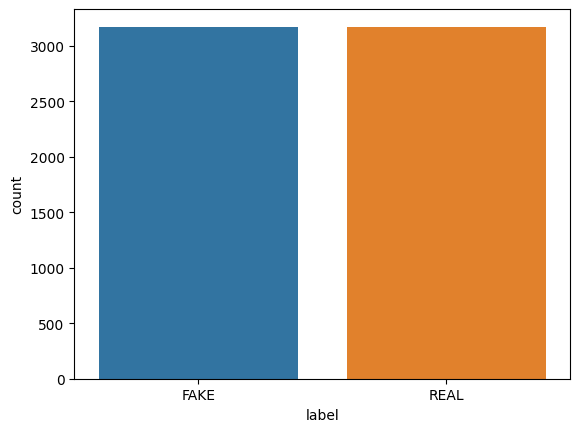

In [7]:
sns.countplot(data=df, x='label')
plt.show()

**The Dataset is well balanced**

# Data Prep part I

In [8]:
df['label'] = (df['label'] == 'FAKE').astype('int') # turning labels into 1 or 0. 1 -> Fake, 0 -> Real
df['title_text'] = df['title'] + ". " + df['text'] # merging title and text

In [9]:
df = df.reindex(columns=['label', 'title', 'text', 'title_text']) # reindexing and arranging columns
df.head()

,label,title,text,title_text
0,1,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",You Can Smell Hillary’s Fear. Daniel Greenfiel...
1,1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,Watch The Exact Moment Paul Ryan Committed Pol...
2,0,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,Kerry to go to Paris in gesture of sympathy. U...
3,1,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",Bernie supporters on Twitter erupt in anger ag...
4,0,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,The Battle of New York: Why This Primary Matte...


In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train_test_ratio = 0.10
train_valid_ratio = 0.80

In [12]:
# Split according to label
df_real = df.loc[df['label'] == 0]
df_fake = df.loc[df['label'] == 1]

In [13]:
df_real_full_train, df_real_test = train_test_split(df_real, test_size=train_test_ratio, random_state=1)
df_fake_full_train, df_fake_test = train_test_split(df_fake, test_size=train_test_ratio, random_state=1)

In [14]:
df_real_train, df_real_valid = train_test_split(df_real_full_train, train_size=train_valid_ratio, random_state=1)
df_fake_train, df_fake_valid = train_test_split(df_fake_full_train, train_size=train_valid_ratio, random_state=1)

In [15]:
# Concatenate splits of different labels
df_train = pd.concat([df_real_train, df_fake_train], ignore_index=True, sort=False)
df_valid = pd.concat([df_real_valid, df_fake_valid], ignore_index=True, sort=False)
df_test = pd.concat([df_real_test, df_fake_test], ignore_index=True, sort=False)

In [16]:
print(f"Training shape {df_train.shape}")
print(f"Validation shape {df_valid.shape}")
print(f"Test shape {df_test.shape}")

Training shape (4559, 4)
Validation shape (1141, 4)
Test shape (635, 4)


In [17]:
# Write preprocessed data
df_train.to_csv('train.csv', index=False)
df_valid.to_csv('valid.csv', index=False)
df_test.to_csv('test.csv', index=False)

# Data Prep part II

In [18]:
source_dir = '/kaggle/working/'

In [19]:
dataset = load_dataset('csv', data_files={
    'train': f"{source_dir}train.csv",
    'valid': f"{source_dir}valid.csv",
    'test': f"{source_dir}test.csv",
})

Generating train split: 0 examples [00:00, ? examples/s]

Generating valid split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [20]:
def tokenize_function(example):
    return tokenizer(example['title_text'], padding='max_length', truncation=True)

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
tokenized_dataset = dataset.map(tokenize_function, batched=True)

tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/4559 [00:00<?, ? examples/s]

Map:   0%|          | 0/1141 [00:00<?, ? examples/s]

Map:   0%|          | 0/635 [00:00<?, ? examples/s]

In [21]:
# sent = 'this is a normal text'
# # Encode the sentence
# encoded = tokenizer(sent, padding='max_length', truncation=True, return_tensors = 'pt')
# input_ids = encoded['input_ids']
# attn_mask = encoded['attention_mask']

In [22]:
# print(input_ids)
# print(attn_mask)

In [23]:
train_ds = tokenized_dataset['train'] 
val_ds = tokenized_dataset['valid'] 
test_ds = tokenized_dataset['test'] 

In [24]:
# Define DataLoader parameters
batch_size = 32

# Create DataLoader objects for batching
train_dataloader = DataLoader(train_ds, shuffle=True, batch_size=batch_size)
valid_dataloader = DataLoader(val_ds, shuffle=False, batch_size=batch_size)
test_dataloader = DataLoader(test_ds, shuffle=False, batch_size=batch_size)

# Model Building

In [25]:
class BI_LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=300, dimension=128, dropout=0.5):
        super(BI_LSTM, self).__init__()
        
        self.dimension = dimension
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim,
                           hidden_size=self.dimension,
                           num_layers=1,
                           batch_first=True,
                           bidirectional=True)
        self.drop = nn.Dropout(p=dropout)
        self.fc = nn.Linear(2 * dimension, 1)
        
    def forward(self, text, text_len):
        
        text_emb = self.embedding(text)
        
        packed_input = pack_padded_sequence(text_emb, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        
        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_feat = self.drop(out_reduced)
        
        text_feat = self.fc(text_feat)
        text_feat = torch.squeeze(text_feat, 1)
        text_out = torch.sigmoid(text_feat)
        
        return text_out
        

In [26]:
# embd = nn.Embedding(len(tokenizer.get_vocab()), 300)
# tl = torch.tensor(3)
# txt_emdb = embd(torch.tensor([1, 100, 23]))
# packed_input = pack_padded_sequence(txt_emdb, tl.to('cpu'), batch_first=True, enforce_sorted=False)
# packed_input

In [27]:
# print(txt_emdb.shape)

# Save and Load

In [32]:
def save_checkpoint(save_path, model, optimizer, valid_loss):
    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                 'optimizer_state_dict': optimizer.state_dict(),
                 'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f"Model saved to ----> {save_path}")
    
def load_checkpoint(load_path, model, optimizer):
    if load_path == None:
        return 
    
    state_dict = torch.load(load_path, map_location=device)
    print(f"Model loaded from <---- {load_path}")
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']
    
def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ----> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <---- {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [33]:
# Training functin

def train(model,
          optimizer,
          criterion,
          train_loader,
          valid_loader,
          num_epochs,
          eval_every,
          file_path,
          best_valid_loss=float("inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0 
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []
    
    # training loop
    
    model.train()
    for epoch in range(num_epochs):
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device).float()
            text_len = attention_mask.sum(dim=1).to('cpu')
            
            # forward pass
            output = model(input_ids, text_len)
            
            # loss and gradient descent
            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # update running values
            running_loss += loss.item()
            global_step += 1
            
            # Evaluation 
            if global_step % eval_every == 0:
                # set the model to the evaluation mode
                model.eval()
                with torch.no_grad():
                    for batch in valid_loader:
                        input_ids = batch['input_ids'].to(device)
                        attention_mask = batch['attention_mask'].to(device)
                        labels = batch['label'].to(device).float()
                        text_len = attention_mask.sum(dim=1).to('cpu')
                        
                        output = model(input_ids, text_len)
                        loss = criterion(output, labels)
                        valid_running_loss += loss.item()
                    
                    # calculate the avg losses
                    avg_train_loss = running_loss / eval_every
                    avg_valid_loss = valid_running_loss / len(valid_loader)
                    train_loss_list.append(avg_train_loss)
                    valid_loss_list.append(avg_valid_loss)
                    global_steps_list.append(global_step)
                    
                    # reset the running losses
                    running_loss = 0.0
                    valid_running_loss = 0.0
                    model.train()
                    
                    # Print progress
                    print(f'Epoch [{epoch+1}/{num_epochs}], Step [{global_step}/{num_epochs*len(train_loader)}], '
                          f'Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}')
                    
                    # saving
                    if best_valid_loss > avg_valid_loss:
                        best_valid_loss = avg_valid_loss
                        save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                        save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [34]:
# instantiate the model instance
vocab_size = len(tokenizer.get_vocab())
model = BI_LSTM(vocab_size=vocab_size, dimension=300).to(device)

In [35]:
# Model params

OPTIMIZER = optim.AdamW(model.parameters(), lr=0.001)
CRITERION = nn.BCELoss()
TRAIN_LOADER = train_dataloader
VALID_LOADER = valid_dataloader
NUM_EPOCHS = 10
EVAL_EVERY = len(train_dataloader) // 2
FILE_PATH = '/kaggle/working/'

In [36]:
# start the training 

train(model=model,
      optimizer=OPTIMIZER,
      criterion=CRITERION,
      train_loader=TRAIN_LOADER,
      valid_loader=VALID_LOADER,
      eval_every=EVAL_EVERY,
      num_epochs=NUM_EPOCHS,
      file_path=FILE_PATH
     )

Epoch [1/10], Step [71/1430], Train Loss: 0.5908, Valid Loss: 0.4395
Model saved to ----> /kaggle/working//model.pt
Model saved to ----> /kaggle/working//metrics.pt
Epoch [1/10], Step [142/1430], Train Loss: 0.4287, Valid Loss: 0.3095
Model saved to ----> /kaggle/working//model.pt
Model saved to ----> /kaggle/working//metrics.pt
Epoch [2/10], Step [213/1430], Train Loss: 0.2707, Valid Loss: 0.3736
Epoch [2/10], Step [284/1430], Train Loss: 0.2517, Valid Loss: 0.3205
Epoch [3/10], Step [355/1430], Train Loss: 0.1472, Valid Loss: 0.2880
Model saved to ----> /kaggle/working//model.pt
Model saved to ----> /kaggle/working//metrics.pt
Epoch [3/10], Step [426/1430], Train Loss: 0.1623, Valid Loss: 0.2576
Model saved to ----> /kaggle/working//model.pt
Model saved to ----> /kaggle/working//metrics.pt
Epoch [4/10], Step [497/1430], Train Loss: 0.0737, Valid Loss: 0.2663
Epoch [4/10], Step [568/1430], Train Loss: 0.0695, Valid Loss: 0.2708
Epoch [5/10], Step [639/1430], Train Loss: 0.0175, Valid 

/tmp/ipykernel_36/1864825584.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(load_path, map_location=device)


Model loaded from <---- /kaggle/working//metrics.pt


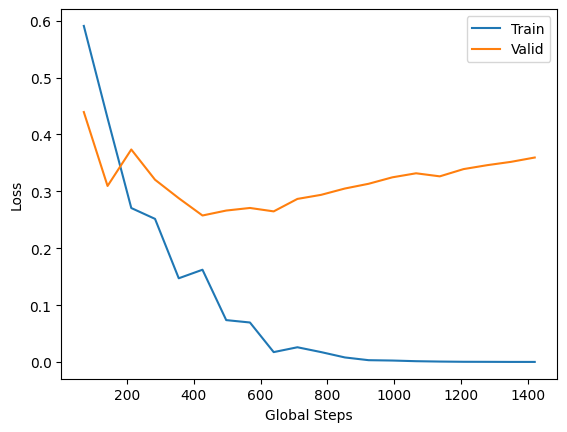

In [37]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(FILE_PATH + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [38]:
# Evaluation Function

def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []
    
    # setting to evaluation mode
    model.eval()
    with torch.no_grad():
         for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device).float()
            text_len = attention_mask.sum(dim=1).to('cpu')
            
            output = model(input_ids, text_len)
            
            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

/tmp/ipykernel_36/1864825584.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(load_path, map_location=device)


Model loaded from <---- /kaggle/working//model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.8939    0.8770    0.8854       317
           0     0.8796    0.8962    0.8879       318

    accuracy                         0.8866       635
   macro avg     0.8868    0.8866    0.8866       635
weighted avg     0.8867    0.8866    0.8866       635



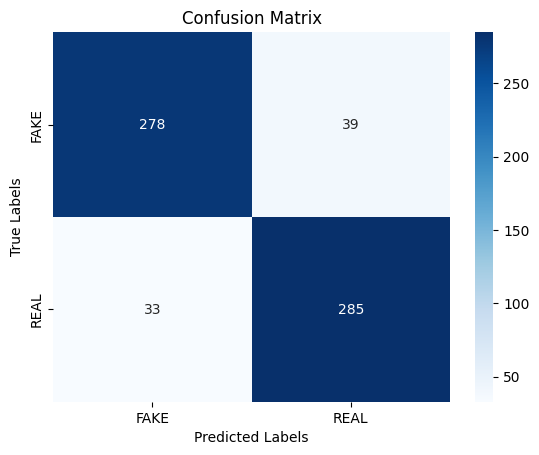

In [39]:
best_model = BI_LSTM(vocab_size=vocab_size, dimension=300).to(device)
optimizer = optim.AdamW(best_model.parameters(), lr=0.001)

load_checkpoint(FILE_PATH + '/model.pt', best_model, optimizer)
evaluate(best_model, test_dataloader)

In [58]:
def predict_single(data, model, tokenizer, threshold=0.5):
    # tokenize data
    
    encoded = tokenizer(data, padding='max_length', truncation=True, return_tensors = 'pt')
    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)
    text_len = attention_mask.sum(dim=1).to('cpu')
    
    model.eval()
    with torch.no_grad():
        output = model(input_ids, text_len)

#         output = (output > threshold).int()
#         return output.tolist()
        return output
#         y_pred.extend(output.tolist())
#         y_true.extend(labels.tolist())

In [59]:
txt = df_test.loc[df_test['label'] == 1, 'title_text'][318]
out = predict_single(txt, model=best_model, tokenizer=tokenizer)

In [60]:
out

tensor([0.9994], device='cuda:0')

In [52]:
df_test.loc[df_test['label'] == 1]

,label,title,text,title_text
318,1,NEW WIKILEAK : Top Clinton Operative Believes ...,NEW WIKILEAK : Top Clinton Operative Believes ...,NEW WIKILEAK : Top Clinton Operative Believes ...
319,1,"“If Trump Loses, I’m Grabbing My Musket”: Form...",324 324 likes \nHis heated rhetoric is a respo...,"“If Trump Loses, I’m Grabbing My Musket”: Form..."
320,1,AIDS “Patient Zero” Not the Source of the Outb...,AIDS “Patient Zero” Not the Source of the Outb...,AIDS “Patient Zero” Not the Source of the Outb...
321,1,Dems sue GOP over Trump's 'rigged' complaints,Dems sue GOP over Trump's 'rigged' complaints ...,Dems sue GOP over Trump's 'rigged' complaints....
322,1,I thought I was just scared of Trump – but it’...,Israeli official secretly visits Dubai: Report...,I thought I was just scared of Trump – but it’...
...,...,...,...,...
630,1,"Without Bold Agenda, Warn Progressives, A Clin...","Without Bold Agenda, Warn Progressives, A Clin...","Without Bold Agenda, Warn Progressives, A Clin..."
631,1,FBI debunks Hillary's Conspiracy Theory: Trump...,\nFBI officials say their investigation into l...,FBI debunks Hillary's Conspiracy Theory: Trump...
632,1,But How Do You Use Nonviolence Against a Nuke?,"The ""Baker"" explosion, part of Operation Cross...",But How Do You Use Nonviolence Against a Nuke?...
633,1,Carl G. Jung Attitude Types and the Sash of So...,Carl G. Jung Attitude Types and the Sash of So...,Carl G. Jung Attitude Types and the Sash of So...


'NEW WIKILEAK : Top Clinton Operative Believes “BLACK VOTERS ARE STUPID” – TruthFeed. NEW WIKILEAK : Top Clinton Operative Believes “BLACK VOTERS ARE STUPID” NEW WIKILEAK : Top Clinton Operative Believes “BLACK VOTERS ARE STUPID” Videos By TruthFeedNews November 2, 2016 \nA new email released as part of the Wikileaks Podesta dump features Clinton ally Brent Budowsky exposing Hillary operative David Brock of having a plan that relied upon black voters being “stupid.” \nWhy is their ZERO reporting of this on mainstream news? \nWatch the video: \nSupport the Trump Movement and help us fight Liberal Media Bias. Please LIKE and SHARE this story on Facebook or Twitter. \n'